# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [3]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
#import seaborn as sns


In [5]:
workdir='./work/'
datadir='./data/'
outdir='./out/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

./data/butane.pdb
./data/butane.gaff2.xml


In [6]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [7]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,33.04941794857018,283.35671531798624
2000,36.88003449829686,242.68739733310431


In [8]:
os.path.join(workdir, "butane_sim.dcd")

'./work/butane_sim.dcd'

In [9]:
# import time as time

# print('Running Production...')

# # Begin timer
# tinit=time.time()

# # Clear simulation reporters
# simulation.reporters.clear()

# # Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# # output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
# simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
#     step=True, time=True, potentialEnergy=True, temperature=True, 
#     speed=True, separator=','))

# # write out a trajectory (i.e., coordinates vs. time) to a DCD
# # file every 100 steps - 0.2 ps
# simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# # run the simulation for 1.0x10^7 steps - 20 ns
# simulation.step(10000000)

# # End timer
# tfinal=time.time()
# print('Done!')
# print('Time required for simulation:', tfinal-tinit, 'seconds')

In [10]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x27b5c68bc10>

In [11]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [12]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x27b5fe9f250>

In [13]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [14]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


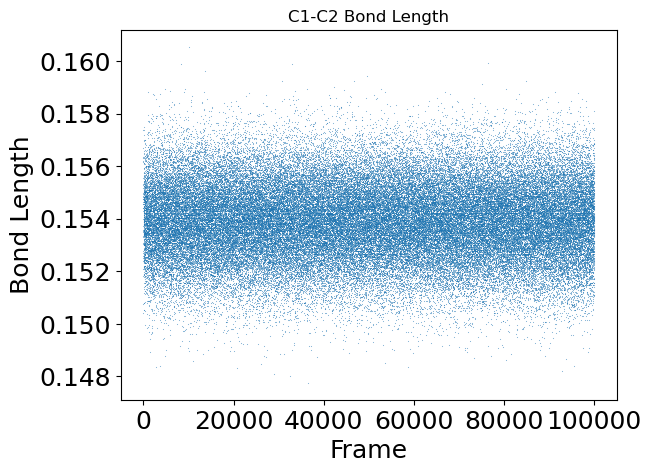

In [15]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000])

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

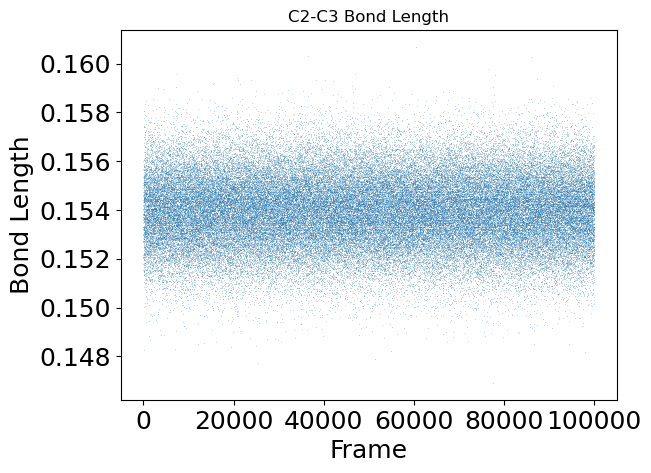

In [16]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

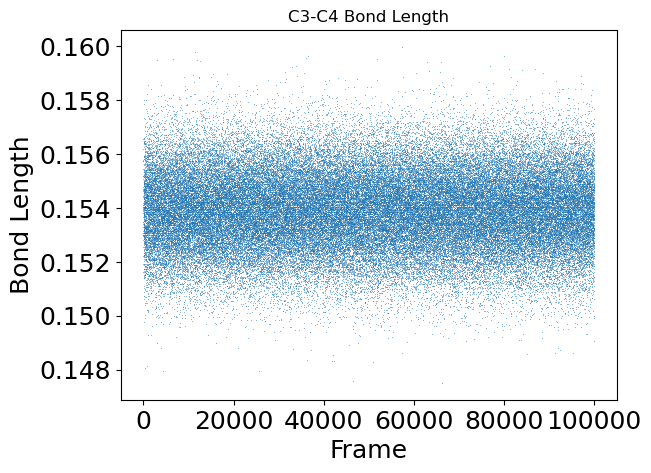

In [17]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

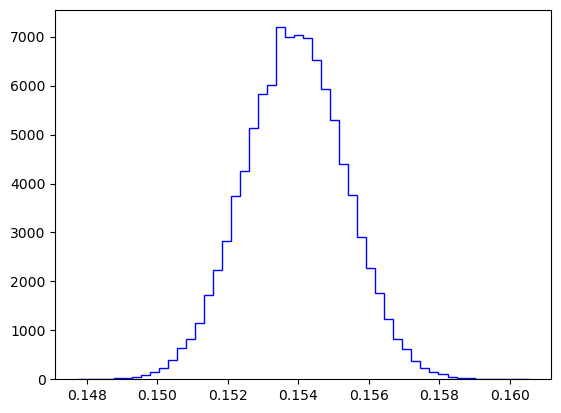

In [18]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

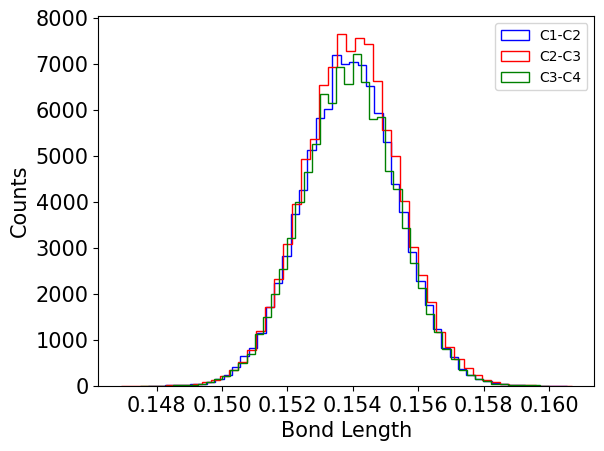

In [19]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

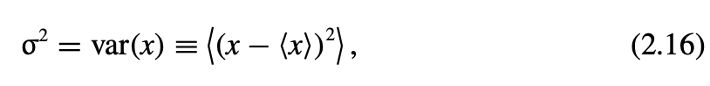

In [20]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [21]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 2.0424097e-06 C1-C2 standard deviation: 0.0014291290119839276
C2-C3 variance: 2.0734362e-06 C1-C2 standard deviation: 0.0014399431360822687
C3-C4 variance: 2.0734362e-06 C1-C2 standard deviation: 0.001429076667298055


In [22]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15390146 variance: 2.0424097e-06 std-dev: 0.001429129
C2-C3 average: 0.15395184 variance: 2.0734362e-06 std-dev: 0.0014399431
C3-C4 average: 0.15390126 variance: 2.0422601e-06 std-dev: 0.0014290767


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [23]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: [0.50013989 0.07697559]


C:\Users\S.J. KIM\AppData\Local\Temp\ipykernel_17052\1769237437.py:9: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


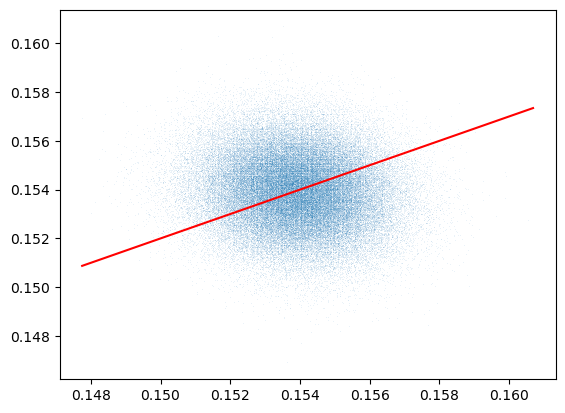

r2: -0.10237060707571341
Line Parameters: [0.49997783 0.07695065]


C:\Users\S.J. KIM\AppData\Local\Temp\ipykernel_17052\1769237437.py:22: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


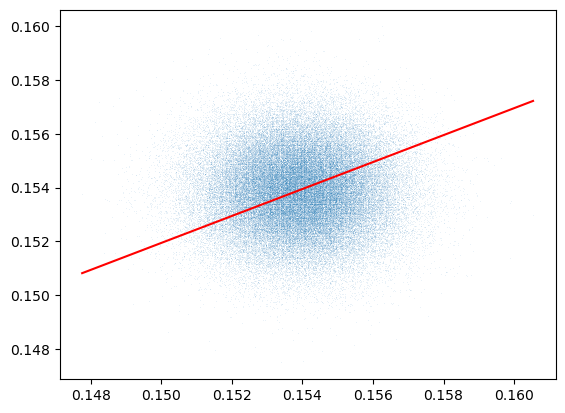

r2: 0.0036073707988470622


In [24]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

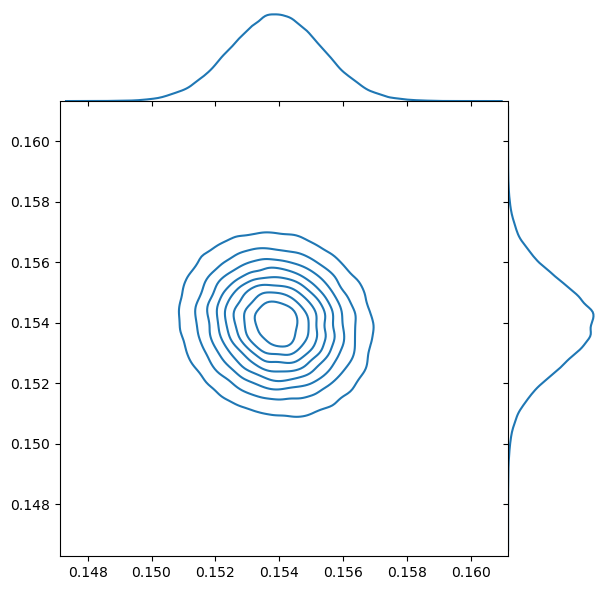

In [44]:
import seaborn as sns
#plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

import numpy as np

# Replace infinity values with NaN
CCCC_dihe = np.where(np.isinf(CCCC_dihe), np.nan, CCCC_dihe)

D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

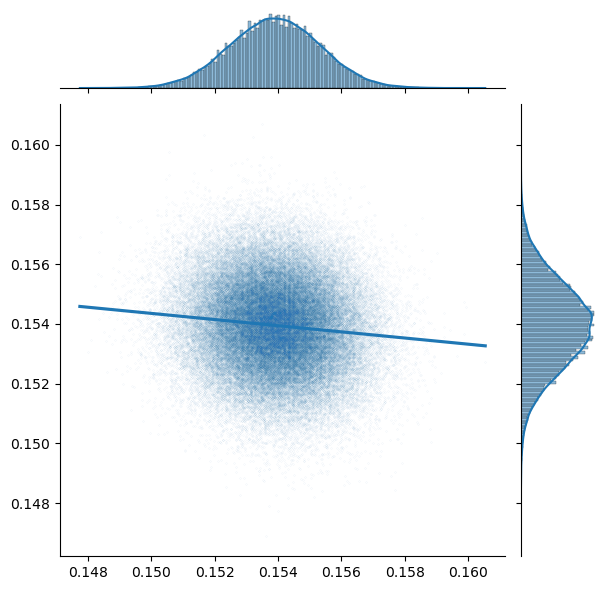

In [30]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

#HERE IS MY ANSWER 
#Answer: The r squared values r2: -0.10237060707571333 and r2: 0.0036073707988470583 are distinguishable between fits

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

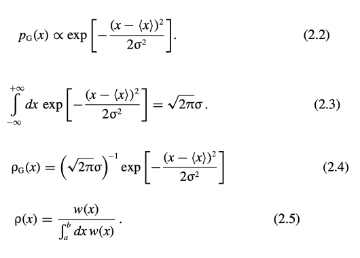
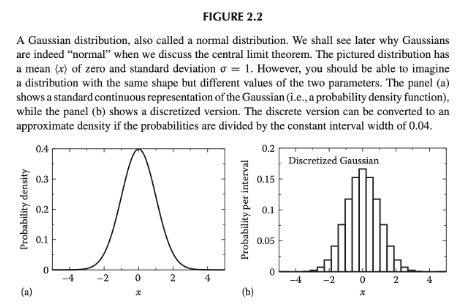

[    0     4    29   100   390  1337  3193  6652 11411 15766 17887 16697
 12644  7722  3954  1530   496   154    28     5] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.17975956818369293 x_0: 0.15390721324767204 fit_sigma: -0.001443176763489012


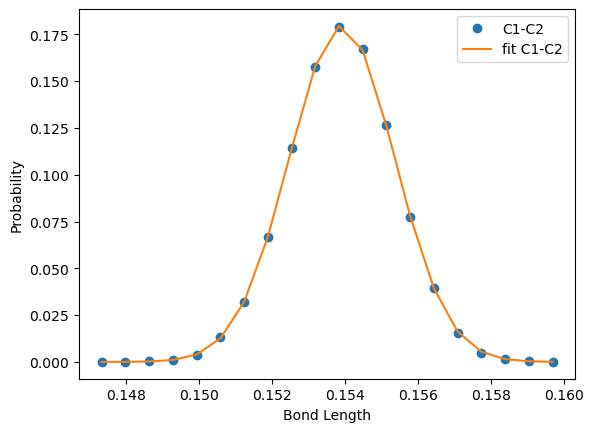

In [31]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

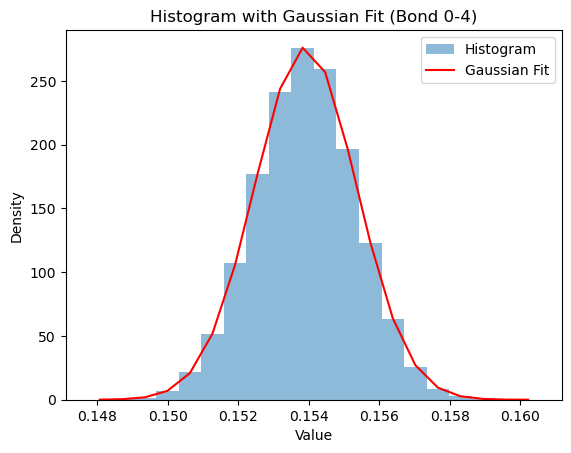

Density: [1.09460818e-01 5.62941351e-01 1.72009857e+00 6.72402170e+00
 2.20798108e+01 5.17906043e+01 1.06911945e+02 1.77263977e+02
 2.41392379e+02 2.75559792e+02 2.59099794e+02 1.96216336e+02
 1.23237244e+02 6.34560001e+01 2.56451060e+01 8.55358109e+00
 2.76779498e+00 5.47304092e-01 6.25490391e-02 3.12745195e-02]
Centers of bins: [0.14806953 0.14870903 0.14934853 0.14998803 0.15062752 0.15126702
 0.15190652 0.15254602 0.15318552 0.15382501 0.15446451 0.155104
 0.1557435  0.156383   0.15702249 0.15766199 0.15830149 0.15894099
 0.15958048 0.16021998]
Parameters of Gaussian fit (amplitude, mean, std dev): [2.76422166e+02 1.53910144e-01 1.44416215e-03]


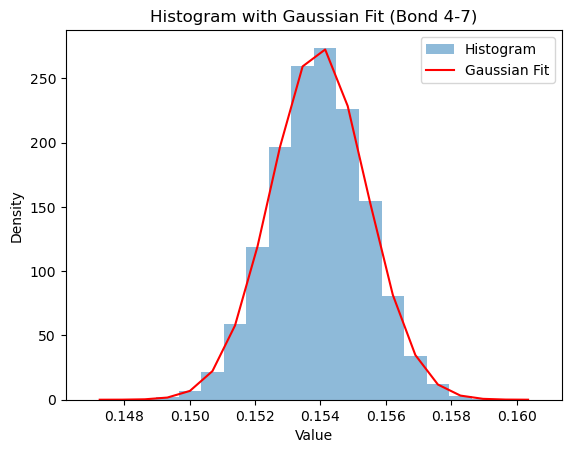

Density: [1.45128488e-02 8.70752095e-02 4.78924009e-01 1.95919221e+00
 7.11129590e+00 2.16096318e+01 5.90660171e+01 1.18628026e+02
 1.96746436e+02 2.59286556e+02 2.73886482e+02 2.26090782e+02
 1.55011738e+02 8.10234825e+01 3.38004248e+01 1.25681270e+01
 3.16373261e+00 5.51488253e-01 1.45125349e-01 4.35385463e-02]
Centers of bins: [0.14725265 0.14794171 0.14863077 0.14931981 0.15000886 0.15069792
 0.15138696 0.152076   0.15276507 0.15345412 0.15414315 0.15483221
 0.15552127 0.15621032 0.15689936 0.15758842 0.15827747 0.15896651
 0.15965557 0.16034463]
Parameters of Gaussian fit (amplitude, mean, std dev): [2.74948344e+02 1.53949654e-01 1.45038700e-03]


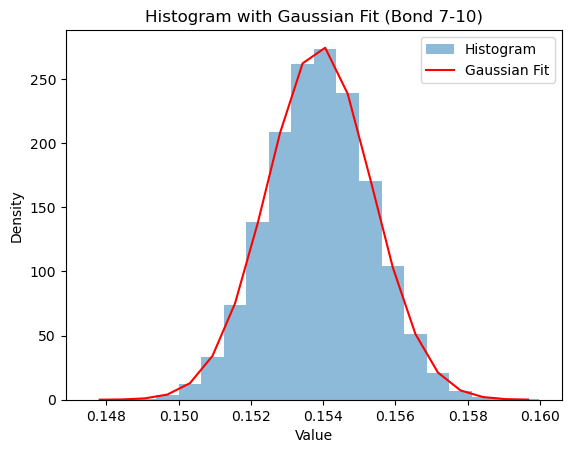

Density: [8.01587004e-02 1.92380881e-01 6.25222927e-01 3.86364936e+00
 1.24245986e+01 3.33139559e+01 7.41948931e+01 1.38174267e+02
 2.08572939e+02 2.61878474e+02 2.73517518e+02 2.39401975e+02
 1.70814110e+02 1.04559009e+02 5.11572826e+01 2.07130082e+01
 7.05396564e+00 1.93979421e+00 4.96983943e-01 1.92380881e-01]
Centers of bins: [0.14781784 0.1484416  0.14906538 0.14968914 0.1503129  0.15093666
 0.15156043 0.15218419 0.15280797 0.15343173 0.15405549 0.15467925
 0.15530303 0.1559268  0.15655056 0.15717432 0.15779808 0.15842184
 0.15904562 0.15966938]
Parameters of Gaussian fit (amplitude, mean, std dev): [2.76026602e+02 1.53896095e-01 1.44705684e-03]


In [32]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mdtraj as md

def gauss(x, a, x0, sigma):
    """
    Gaussian function.

    Parameters:
        x (array-like): Independent variable.
        a (float): Amplitude.
        x0 (float): Mean.
        sigma (float): Standard deviation.

    Returns:
        y (array-like): Gaussian function values.
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Load trajectory data
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)

def fit_histogram_with_gaussian(data, bins=20, plot=True, bond_indices=None):
    """
    Fit a histogram with a Gaussian function.

    Parameters:
        data (array-like): Input data.
        bins (int or array_like, optional): Number of bins or bin edges.
        plot (bool, optional): Whether to plot the histogram with the Gaussian fit.
        bond_indices (list, optional): Bond indices indicating the atoms involved in the bond.

    Returns:
        hist (array-like): Histogram values.
        bin_centers (array-like): Centers of histogram bins.
        params (tuple): Fitted parameters of the Gaussian function (mean, std dev, amplitude).
    """
    # Calculate histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Estimate initial guess for parameters
    mean_estimate = np.mean(data)
    std_estimate = np.std(data)
    amplitude_estimate = np.max(hist)

    # Fit Gaussian
    popt, pcov = curve_fit(gauss, bin_centers, hist, p0=[amplitude_estimate, mean_estimate, std_estimate])

    # Calculate Gaussian curve
    fit_y = gauss(bin_centers, *popt)

    # Plot histogram and Gaussian fit
    if plot:
        plt.hist(data, bins=bins, density=True, alpha=0.5, label='Histogram')
        plt.plot(bin_centers, fit_y, 'r-', label='Gaussian Fit')
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Density')
        if bond_indices:
            bond_name = f'Bond {bond_indices[0]}-{bond_indices[1]}'
            plt.title(f'Histogram with Gaussian Fit ({bond_name})')
        else:
            plt.title('Histogram with Gaussian Fit')
        plt.show()

    return hist, bin_centers, popt

# Define bond indices and corresponding titles
bond_indices_list = [[[0, 4], 'C1-C2'], [[4, 7], 'C2-C3'], [[7, 10], 'C3-C4']]

# Iterate over bond indices and create histograms with Gaussian fits
for bond_indices, bond_title in bond_indices_list:
    # Compute bond lengths
    bond_lengths = md.compute_distances(traj, [bond_indices])[:, 0]

    # Fit histogram with Gaussian
    hist, bin_centers, params = fit_histogram_with_gaussian(bond_lengths, bond_indices=bond_indices)

    print("Density:", hist)
    print("Centers of bins:", bin_centers)
    print("Parameters of Gaussian fit (amplitude, mean, std dev):", params)

#USE THE FUNCTION TO ITERATE OVER ALL CC BONDS, plot the densities and the fits 

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

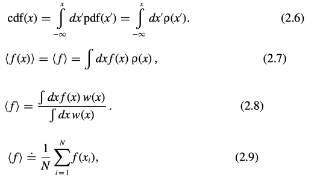

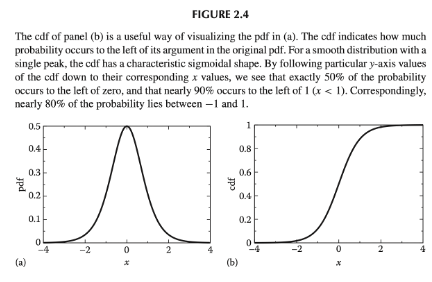

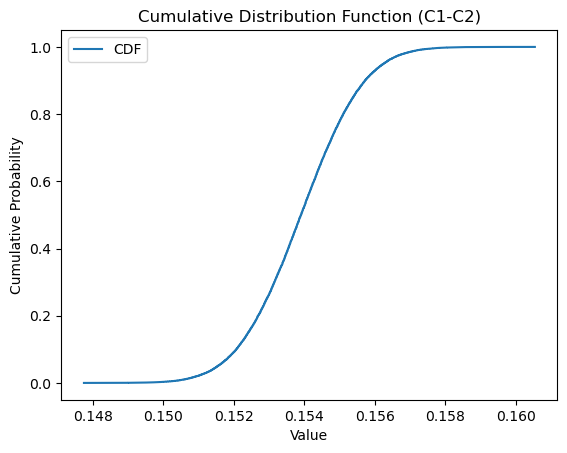

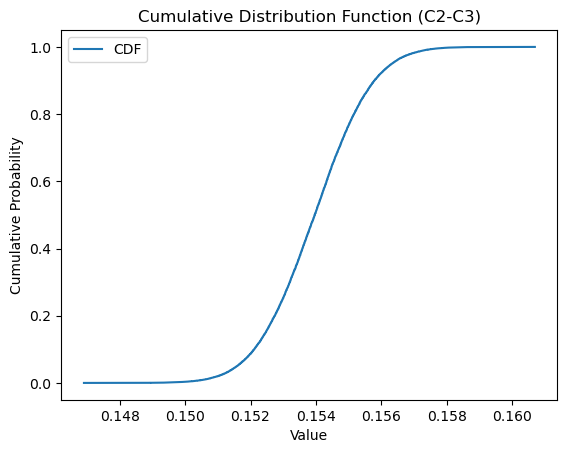

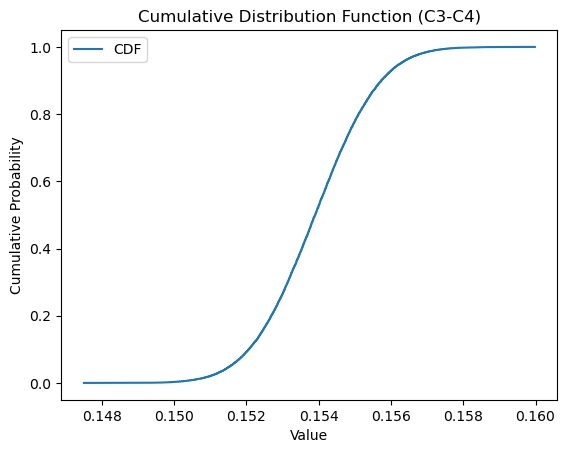

In [33]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#TRY THIS FUNCTION:
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
#ADD CODE FOR CDFs HERE#

import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

# Load trajectory data
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)

# Define bond indices and corresponding titles
bond_indices_list = [[[0, 4], 'C1-C2'], [[4, 7], 'C2-C3'], [[7, 10], 'C3-C4']]

# Iterate over bond indices and create plots
for bond_indices, bond_title in bond_indices_list:
    # Compute bond lengths
    bond_lengths = md.compute_distances(traj, [bond_indices])[:, 0]

    # Plot CDF
    sorted_data = np.sort(bond_lengths)
    yvals = np.linspace(0, 1, len(sorted_data))
    
    plt.plot(sorted_data, yvals, label='CDF')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.title(f'Cumulative Distribution Function ({bond_title})')
    plt.show()


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle ***
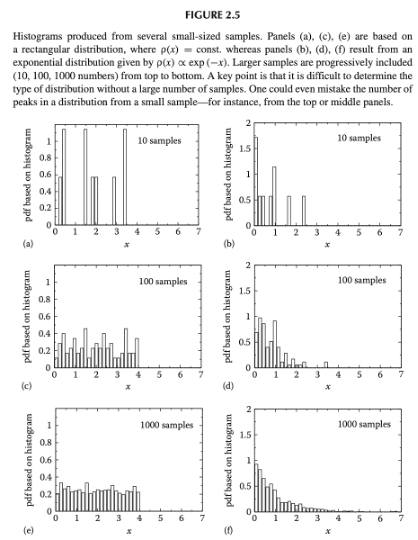

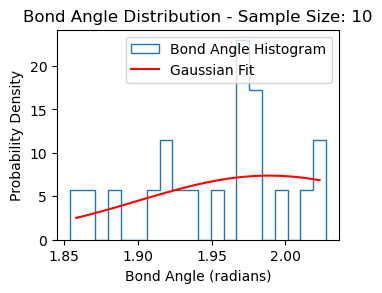

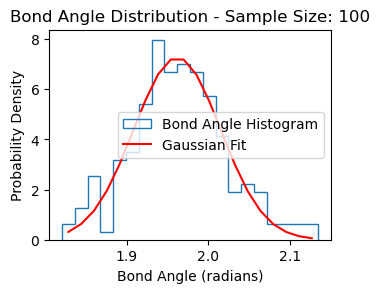

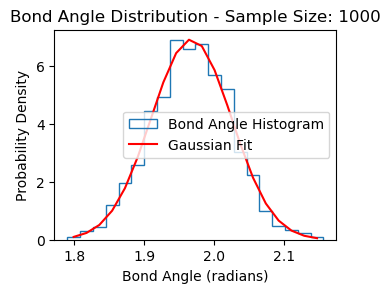

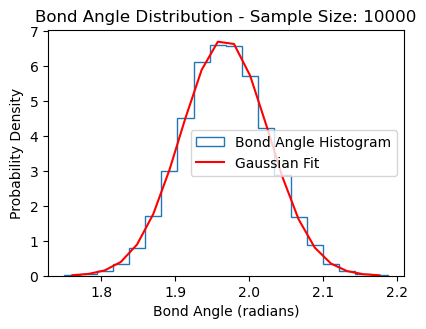

In [35]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mdtraj as md

# Load trajectory data
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)

# Function to fit Gaussian
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Function to compute bond angles
def compute_bond_angles(traj, atom_indices):
    return md.compute_angles(traj, atom_indices)

# Generate random frames for different sample sizes
sample_sizes = [10, 100, 1000, 10000]
sample_trajectories = [traj[np.random.randint(len(traj), size=size)] for size in sample_sizes]

# Define bond angle indices
bond_angle_indices = [[0, 4, 7], [4, 7, 10]]  # Example bond angle indices

# Calculate bond angles and fit Gaussian for each sample trajectory
for i, sample_traj in enumerate(sample_trajectories, start=1):
    plt.figure(figsize=(8, 6))

    # Compute bond angles
    bond_angles = compute_bond_angles(sample_traj, bond_angle_indices).flatten()

    # Plot bond angle histogram
    plt.subplot(2, 2, i)
    bond_angle_hist, bond_angle_bins, _ = plt.hist(bond_angles, bins=20, density=True, histtype='step', label='Bond Angle Histogram')
    bond_angle_bin_centers = (bond_angle_bins[:-1] + bond_angle_bins[1:]) / 2

    # Fit Gaussian to bond angle distribution
    bond_angle_params, _ = curve_fit(gauss, bond_angle_bin_centers, bond_angle_hist, maxfev=2000)  # Increase maxfev
    bond_angle_fit = gauss(bond_angle_bin_centers, *bond_angle_params)
    plt.plot(bond_angle_bin_centers, bond_angle_fit, 'r-', label='Gaussian Fit')
    
    plt.title(f'Bond Angle Distribution - Sample Size: {sample_sizes[i-1]}')
    plt.xlabel('Bond Angle (radians)')
    plt.ylabel('Probability Density')
    plt.legend()

plt.tight_layout()
plt.show()

#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?
#Answer: The increase of sample sizes by 10 fold each time increases the fit adjusted to more data provided.


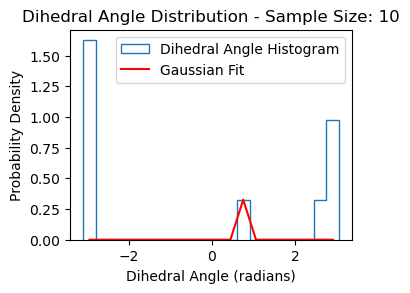

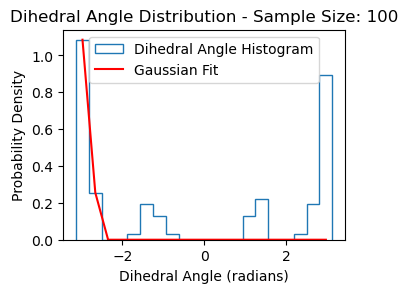

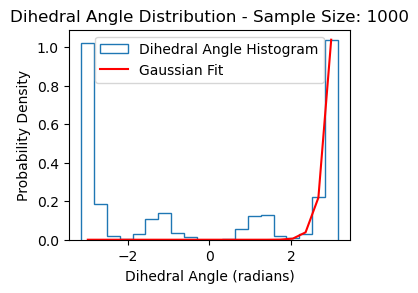

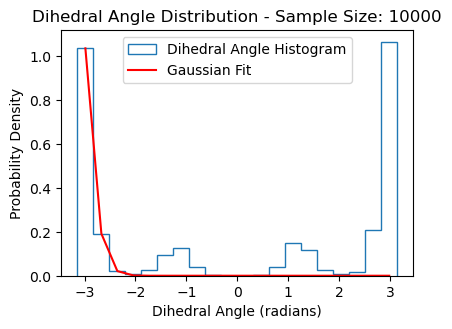

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mdtraj as md

# Load trajectory data
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)

# Function to fit Gaussian
def gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Function to compute dihedral angles
def compute_dihedral_angles(traj, atom_indices):
    return md.compute_dihedrals(traj, atom_indices)

# Generate random frames for different sample sizes
sample_sizes = [10, 100, 1000, 10000]
sample_trajectories = [traj[np.random.randint(len(traj), size=size)] for size in sample_sizes]

# Define dihedral angle indices
dihedral_angle_indices = [[0, 4, 7, 10]]  # Example dihedral angle indices

# Calculate dihedral angles and fit Gaussian for each sample trajectory
for i, sample_traj in enumerate(sample_trajectories, start=1):
    plt.figure(figsize=(8, 6))

    # Compute dihedral angles
    dihedral_angles = compute_dihedral_angles(sample_traj, dihedral_angle_indices).flatten()

    # Plot dihedral angle histogram
    plt.subplot(2, 2, i)
    dihedral_angle_hist, dihedral_angle_bins, _ = plt.hist(dihedral_angles, bins=20, density=True, histtype='step', label='Dihedral Angle Histogram')
    dihedral_angle_bin_centers = (dihedral_angle_bins[:-1] + dihedral_angle_bins[1:]) / 2

    # Fit Gaussian to dihedral angle distribution
    try:
        dihedral_angle_params, _ = curve_fit(gauss, dihedral_angle_bin_centers, dihedral_angle_hist, maxfev=4000)  # Increase maxfev
        dihedral_angle_fit = gauss(dihedral_angle_bin_centers, *dihedral_angle_params)
        plt.plot(dihedral_angle_bin_centers, dihedral_angle_fit, 'r-', label='Gaussian Fit')
    except RuntimeError:
        print(f"Failed to fit Gaussian for sample size: {sample_sizes[i-1]}")

    plt.title(f'Dihedral Angle Distribution - Sample Size: {sample_sizes[i-1]}')
    plt.xlabel('Dihedral Angle (radians)')
    plt.ylabel('Probability Density')
    plt.legend()

plt.tight_layout()
plt.show()

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[1.92946   1.9642153]
 [1.9349695 1.9758505]
 [1.9688907 1.9641949]
 ...
 [1.9465605 1.9411986]
 [2.0316029 1.9215816]
 [2.0647156 2.0602043]]


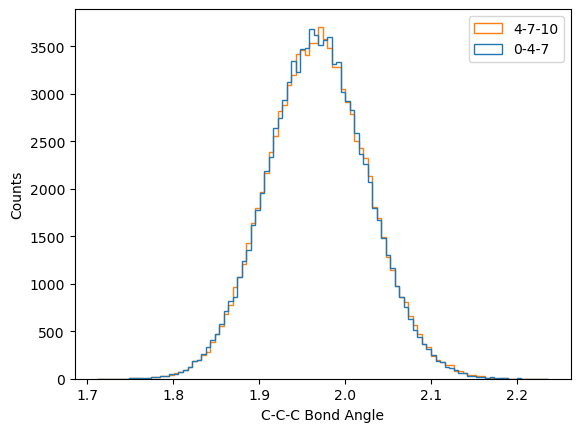

[[ 3.1364186]
 [ 2.9657855]
 [ 3.1379101]
 ...
 [ 2.8601005]
 [-2.9395955]
 [-3.0557897]]
[[ 179.70354]
 [ 169.92699]
 [ 179.789  ]
 ...
 [ 163.87167]
 [-168.4264 ]
 [-175.08385]]


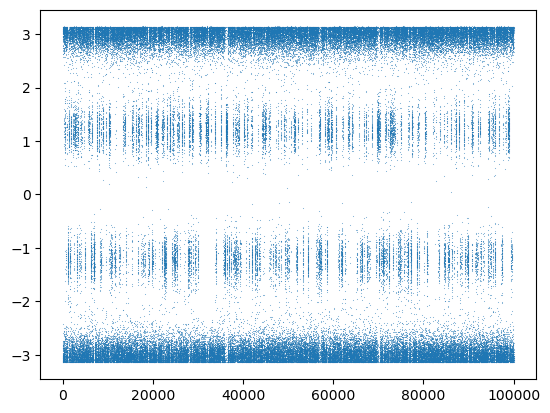

In [37]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mdtraj as md

Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

(0.0, 1000.0)

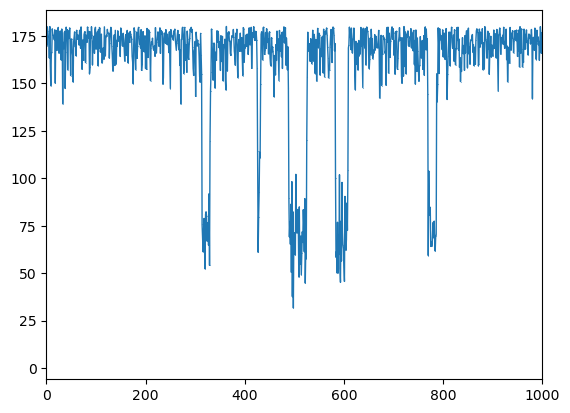

In [38]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,1000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [39]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html

CCCC_dihe = CCCC_torsion[:, 0]

# Find indices where dihedral angle is less than 0 radians
a = np.where(CCCC_dihe < 0)
print("Indices where dihedral angle is less than 0 radians:", a)
print("Dihedral angles where dihedral angle is less than 0 radians:", CCCC_dihe[a])

# Find indices where dihedral angle is greater than -2 radians
b = np.where(CCCC_dihe > -2)
print("Indices where dihedral angle is greater than -2 radians:", b)
print("Dihedral angles where dihedral angle is greater than -2 radians:", CCCC_dihe[b])

# Find indices where dihedral angle is between 0 and -2 radians
c = np.where((CCCC_dihe < 0) & (CCCC_dihe > -2))
print("Indices where dihedral angle is between 0 and -2 radians:", c)

# Probability of being between 0 and -2 radians
probability = len(CCCC_dihe[c]) / len(CCCC_dihe)
print("Probability of being between 0 and -2 radians:", probability)

Indices where dihedral angle is less than 0 radians: (array([    4,     6,     7, ..., 99996, 99998, 99999], dtype=int64),)
Dihedral angles where dihedral angle is less than 0 radians: [-3.0448854 -2.8515844 -3.1410503 ... -3.0938537 -2.9395955 -3.0557897]
Indices where dihedral angle is greater than -2 radians: (array([    0,     1,     2, ..., 99993, 99994, 99997], dtype=int64),)
Dihedral angles where dihedral angle is greater than -2 radians: [3.1364186 2.9657855 3.1379101 ... 3.0987678 3.0682242 2.8601005]
Indices where dihedral angle is between 0 and -2 radians: (array([  426,   427,   428, ..., 99721, 99722, 99723], dtype=int64),)
Probability of being between 0 and -2 radians: 0.0961


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.001834710591643017


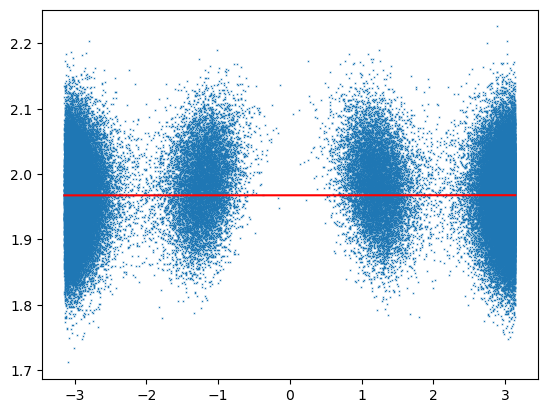

D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\miniconda3\envs\CHEM101\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

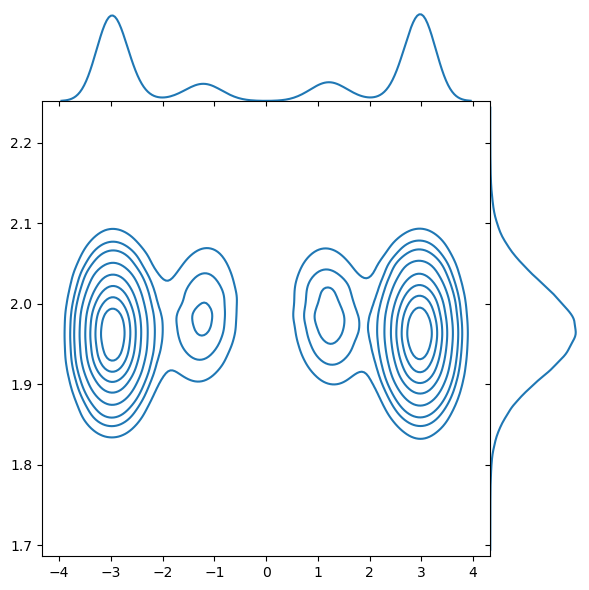

In [40]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

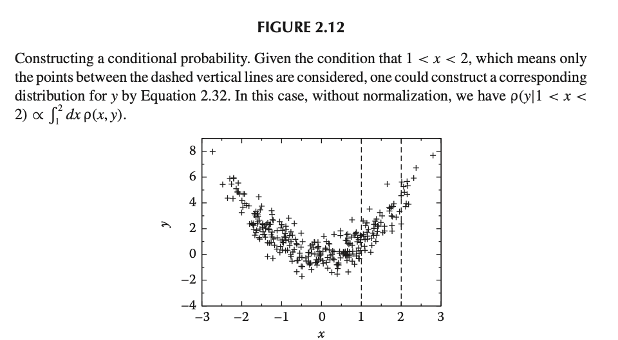

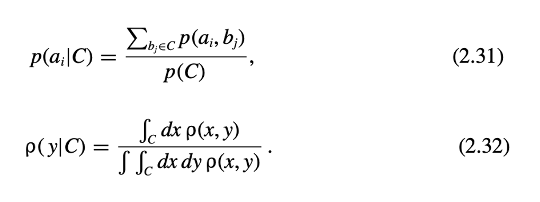

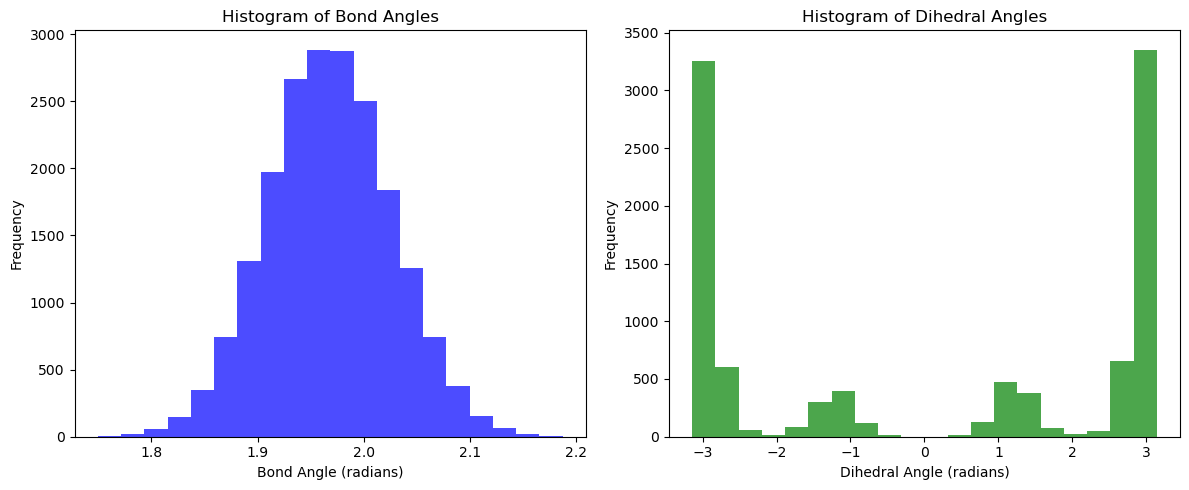

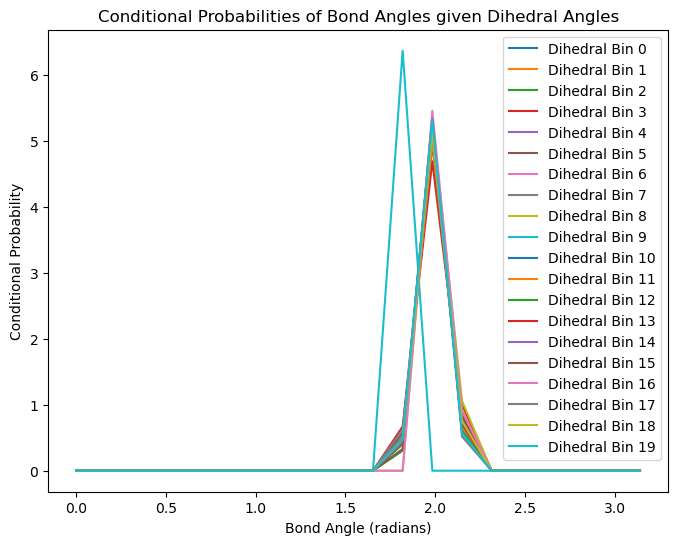

In [47]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined CCCC_dihe, bond_angles, and dihedral_angles arrays

# Plot histograms for bond angles
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(bond_angles, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Bond Angles')
plt.xlabel('Bond Angle (radians)')
plt.ylabel('Frequency')

# Plot histograms for dihedral angles
plt.subplot(1, 2, 2)
plt.hist(dihedral_angles, bins=20, color='green', alpha=0.7)
plt.title('Histogram of Dihedral Angles')
plt.xlabel('Dihedral Angle (radians)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate conditional probabilities
# Define the bins for dihedral angles
dihedral_bins = np.linspace(-np.pi, np.pi, 21)

# Compute conditional probabilities
conditional_probabilities = []
for i in range(len(dihedral_bins) - 1):
    dihedral_bin_min = dihedral_bins[i]
    dihedral_bin_max = dihedral_bins[i + 1]
    
    # Select dihedral angles falling within the current bin
    dihedral_angles_in_bin = np.where((dihedral_angles >= dihedral_bin_min) & (dihedral_angles < dihedral_bin_max))[0]
    
    # Calculate the conditional probability of each bin given bond angle
    conditional_prob = np.histogram(bond_angles[dihedral_angles_in_bin], bins=20, range=(0, np.pi), density=True)[0]
    conditional_probabilities.append(conditional_prob)

# Plot conditional probabilities
plt.figure(figsize=(8, 6))
for i, prob in enumerate(conditional_probabilities):
    plt.plot(np.linspace(0, np.pi, 20), prob, label=f'Dihedral Bin {i}')
plt.title('Conditional Probabilities of Bond Angles given Dihedral Angles')
plt.xlabel('Bond Angle (radians)')
plt.ylabel('Conditional Probability')
plt.legend()
plt.show()

In [48]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.92946   1.9349695 1.9688907 ... 1.9465605 2.0316029 2.0647156]
[1.9349695 1.9688907 1.9928663 ... 1.9465605 2.0316029 2.0647156]
[1.92946   1.9349695 1.9688907 ... 1.8632749 1.9465605 2.0316029]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


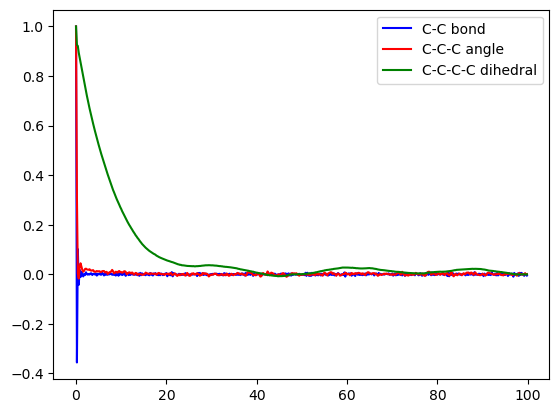

In [49]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

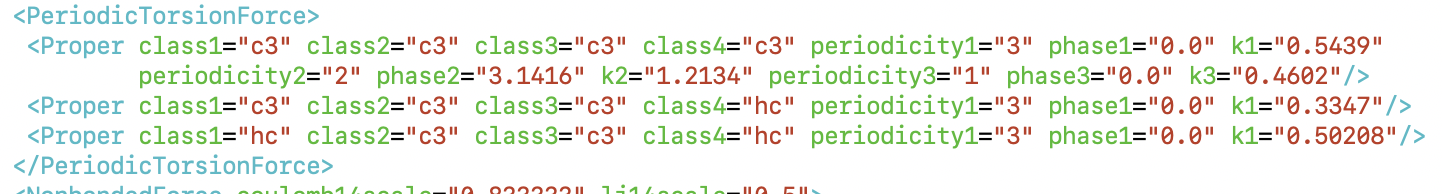

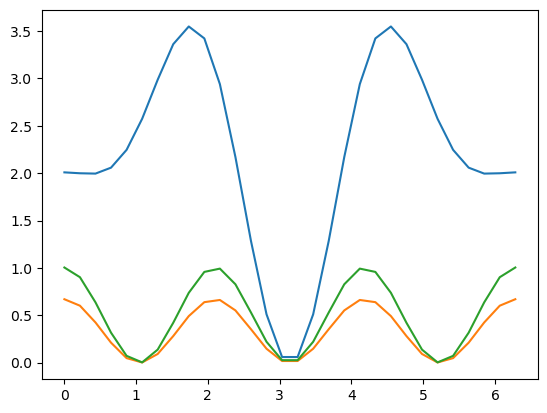

In [50]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)

In [51]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [63]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

In [55]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[-3.133673   -1.1067256   1.1933829  ...  1.2307607  -3.0216227
  -0.83843213]
 [ 2.912773   -1.1144466   0.80834603 ...  1.110059   -3.1119914
  -0.97395337]
 [ 3.0363503  -1.1903913   1.1552844  ...  0.89271504  2.8117032
  -1.2822155 ]
 ...
 [ 2.9235616  -1.3120705   0.77963305 ...  0.65698355  2.6281817
  -1.3088615 ]
 [-2.8576834  -0.95047605  1.4919478  ...  1.2486933  -2.9790504
  -0.83427244]
 [ 2.956642   -1.0786071   0.9971692  ... -0.18318734  1.8700559
  -2.3757806 ]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

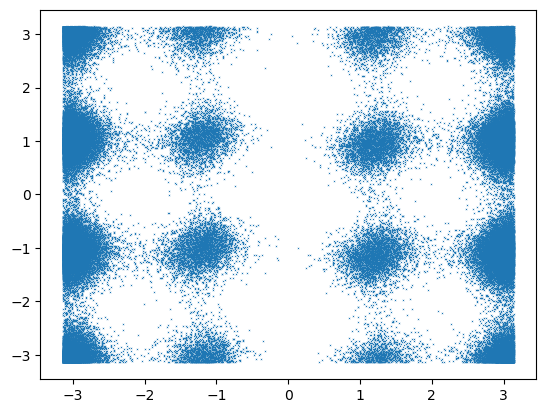

<Figure size 640x480 with 0 Axes>

In [59]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]

#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

#For Example:
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)
plt.show()
plt.clf()

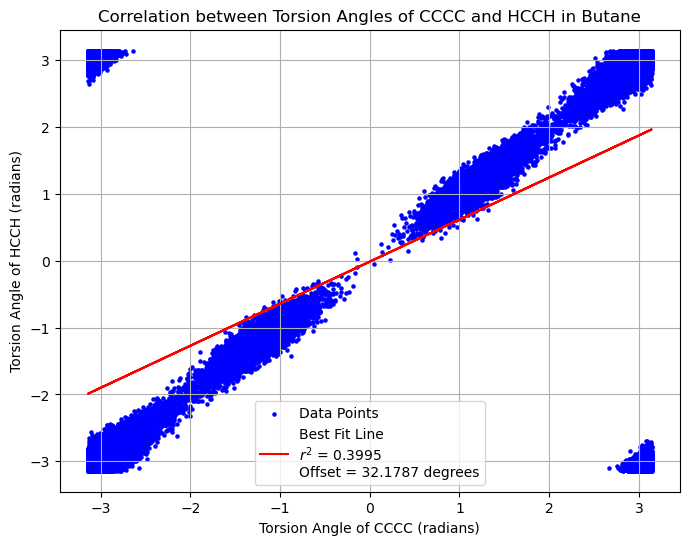

In [83]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]
#For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?

import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

# Assuming you have already defined traj and the indices
CCCC_index = [10, 7, 4, 0]
HCCH_index = [8, 7, 4, 5]

# Compute torsions
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_index])
HCCH_torsion = md.compute_dihedrals(traj, [HCCH_index])

# Extract torsion values
CCCC_torsion_values = CCCC_torsion[:, 0]
HCCH_torsion_values = HCCH_torsion[:, 0]

# Calculate best-fit line
fit_line = np.polyfit(CCCC_torsion_values, HCCH_torsion_values, 1)
fit_line_fn = np.poly1d(fit_line)

# Calculate r^2 value
correlation_matrix = np.corrcoef(CCCC_torsion_values, HCCH_torsion_values)
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient ** 2

# Convert offset to degree angles
offset_radians = np.arctan(fit_line[0])
offset_degrees = np.degrees(offset_radians)

# Plot CCCC vs HCCH torsions with best-fit line
plt.figure(figsize=(8, 6))
plt.scatter(CCCC_torsion_values, HCCH_torsion_values, marker='o', s=5, color='blue', label='Data Points')
plt.plot(CCCC_torsion_values, fit_line_fn(CCCC_torsion_values), color='red', label=f'Best Fit Line\n$r^2$ = {r_squared:.4f}\nOffset = {offset_degrees:.4f} degrees')
plt.xlabel('Torsion Angle of CCCC (radians)')
plt.ylabel('Torsion Angle of HCCH (radians)')
plt.title('Correlation between Torsion Angles of CCCC and HCCH in Butane')
plt.legend()

plt.grid(True)
plt.show()

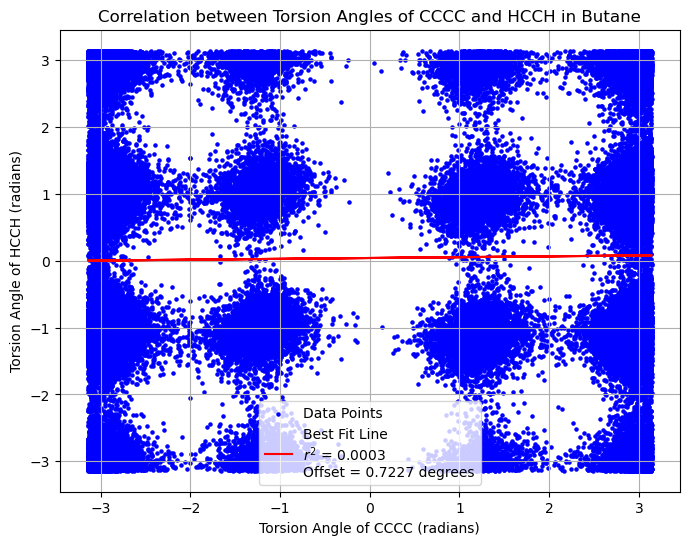

In [86]:
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

#For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

# Assuming you have already defined traj and the indices
CCCC_index = [10, 7, 4, 0]
HCCH_index = [12, 10, 7, 9]

# Compute torsions
CCCC_torsion = md.compute_dihedrals(traj, [CCCC_index])
HCCH_torsion = md.compute_dihedrals(traj, [HCCH_index])

# Extract torsion values
CCCC_torsion_values = CCCC_torsion[:, 0]
HCCH_torsion_values = HCCH_torsion[:, 0]

# Calculate best-fit line
fit_line = np.polyfit(CCCC_torsion_values, HCCH_torsion_values, 1)
fit_line_fn = np.poly1d(fit_line)

# Calculate r^2 value
correlation_matrix = np.corrcoef(CCCC_torsion_values, HCCH_torsion_values)
correlation_coefficient = correlation_matrix[0, 1]
r_squared = correlation_coefficient ** 2

# Convert offset to degree angles
offset_radians = np.arctan(fit_line[0])
offset_degrees = np.degrees(offset_radians)

# Plot CCCC vs HCCH torsions with best-fit line
plt.figure(figsize=(8, 6))
plt.scatter(CCCC_torsion_values, HCCH_torsion_values, marker='o', s=5, color='blue', label='Data Points')
plt.plot(CCCC_torsion_values, fit_line_fn(CCCC_torsion_values), color='red', label=f'Best Fit Line\n$r^2$ = {r_squared:.4f}\nOffset = {offset_degrees:.4f} degrees')
plt.xlabel('Torsion Angle of CCCC (radians)')
plt.ylabel('Torsion Angle of HCCH (radians)')
plt.title('Correlation between Torsion Angles of CCCC and HCCH in Butane')
plt.legend()

plt.grid(True)
plt.show()

**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

In [ ]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT


In [ ]:
####WEEK 1 STOP HERE######

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [ ]:
###SOLUTION#####



***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

In [ ]:
#Compare New Dihedral Distribution HERE)

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


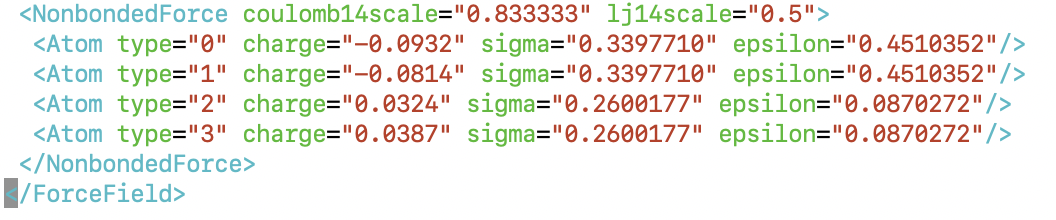




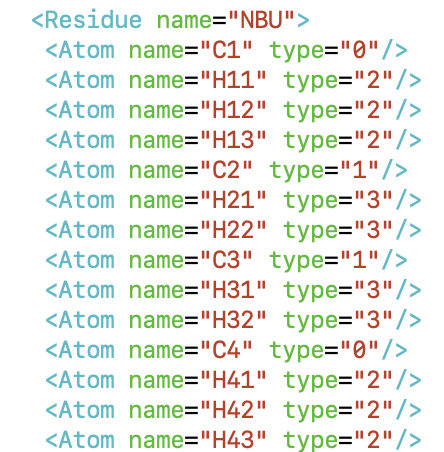

In [ ]:
#Plot LJ and Couloumb Potentionals Here